<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 

In [3]:
import pandas as pd
from pathlib import Path
import joblib
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [4]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [6]:
sys.path = list(set(sys.path))

In [7]:
sys.path

['',
 '/usr/lib/python3.9/lib-dynload',
 '/usr/lib/python39.zip',
 '/content',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/content/drive/MyDrive/NLP/user-defined',
 '/usr/local/lib/python3.9/dist-packages',
 '/root/.ipython',
 '/usr/lib/python3.9',
 '/env/python',
 '/usr/lib/python3/dist-packages']

In [8]:
!pip install torchmetrics -qq

In [9]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [10]:
from data_preparation_imdb_rev0 import *

In [11]:
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [12]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [13]:
multiLabel_Data.shape

(47427, 3)

In [14]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
one_hot_labels= mlb.fit_transform(multiLabel_Data['Tag_Number'])
for i in range(len(mlb.classes_)):
    multiLabel_Data[f"one_hot_{mlb.classes_[i]}"] = one_hot_labels[:, i]

In [16]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number', 'one_hot_0', 'one_hot_1',
       'one_hot_2', 'one_hot_3', 'one_hot_4', 'one_hot_5', 'one_hot_6',
       'one_hot_7', 'one_hot_8', 'one_hot_9'],
      dtype='object')

In [19]:
X_final = multiLabel_Data['cleaned_text'].values

In [20]:
y_final = multiLabel_Data.loc[:, 'one_hot_0':'one_hot_9'].values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [21]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427, 10)


#Create Train/Test/Valid Split

In [22]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4, random_state=42)

In [23]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, random_state=42)

In [24]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [25]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [26]:
print(np.unique(y_train), np.unique(y_valid), np.unique(y_test))

[0 1] [0 1] [0 1]


#Create vocab

In [27]:
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [28]:
len(multilabel_vocab)

90287

In [29]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [30]:
from types import SimpleNamespace

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [31]:
def collate_batch_multilabel(batch, vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return (texts, offsets), labels

In [32]:
from functools import partial
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch_multilabel, vocab=multilabel_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
for (texts, offsets), labels in train_loader:
  print(labels, texts, offsets)
  break

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([  266,    90,  1853,  ...,   140, 58359,    84]) tensor([   0,   51,   96,  126,  161,  242,  321,  473,  486,  509,  534,  588,
         635,  805,  884,  914,  939,  983, 1035, 1090, 1128, 1195, 1226, 1269,
        1391, 1522, 1612, 1686, 1745, 1773, 1851, 1873, 1943, 1996, 2141, 2254,
        2299, 2416, 2466, 2571, 2606, 2647, 2774, 2789, 2811, 2837, 2866, 2959,
        3013, 3120, 3147, 3172, 3227, 3321, 3384, 3399, 3429, 3749, 3801, 3828,
        3895, 3949, 4103, 4115, 4236, 4286, 4315, 4361, 4392, 4602, 4654, 4700,
        4716, 4750, 4833, 4864, 4964, 5036, 5382, 5444, 5476, 5513, 5588, 5627,
        5637, 5705, 5742, 5780, 5858, 5957, 5996, 6064, 6153, 6775, 6819, 7154,
        7762, 7876, 7902, 8063, 8110, 8129, 8169,

<ipython-input-31-0afa194fa4de>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.float32)


#Training Model

In [34]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,
                  criterion=loss_function, device=device)

In [35]:
#from torchmetrics.classification import Accuracy
from torchmetrics.classification import MultilabelHammingDistance
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
train_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
valid_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=1, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

Add a brief description about the metric and why it is a good metric for multilabel classification problems.


Answer: MultilabelHammingDistance is a metric used for evaluating the performance of multilabel classification models. It calculates the proportion of labels that are incorrectly predicted by the model, i.e., the average number of labels that differ between the predicted and true labels across all samples. It takes into account the fact that each sample can have multiple labels, and penalizes the model for making incorrect predictions for each label independently. This is different from other metrics like accuracy, which only consider the overall percentage of correctly classified samples, without taking into account the number of labels each sample has. And robust to imbalanced classes, which is a common issue in multilabel classification problems where some labels might be more frequent than others. Because it considers the total number of label predictions rather than the number of correctly predicted labels, making it less sensitive to the distribution of the labels.

> Indented block



In [36]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.6789035201072693
Expected Theoretical loss: 0.6931471805599453


In [37]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/5 - Train Loss: 0.5849, Train Metric: 0.2767, Train Time: 0:00:03.392841
Epoch 1/5 - Val Loss: 0.2420, Val Metric: 0.0756, Val Time: 0:00:00.893183

Epoch 2/5 - Train Loss: 0.2354, Train Metric: 0.0851, Train Time: 0:00:03.691509
Epoch 2/5 - Val Loss: 0.1661, Val Metric: 0.0611, Val Time: 0:00:00.860377

Epoch 3/5 - Train Loss: 0.1781, Train Metric: 0.0638, Train Time: 0:00:03.652983
Epoch 3/5 - Val Loss: 0.1435, Val Metric: 0.0529, Val Time: 0:00:00.924056

Epoch 4/5 - Train Loss: 0.1517, Train Metric: 0.0537, Train Time: 0:00:03.653909
Epoch 4/5 - Val Loss: 0.1317, Val Metric: 0.0489, Val Time: 0:00:00.914385

Epoch 5/5 - Train Loss: 0.1334, Train Metric: 0.0477, Train Time: 0:00:03.562494
Epoch 5/5 - Val Loss: 0.1229, Val Metric: 0.0457, Val Time: 0:00:00.925509



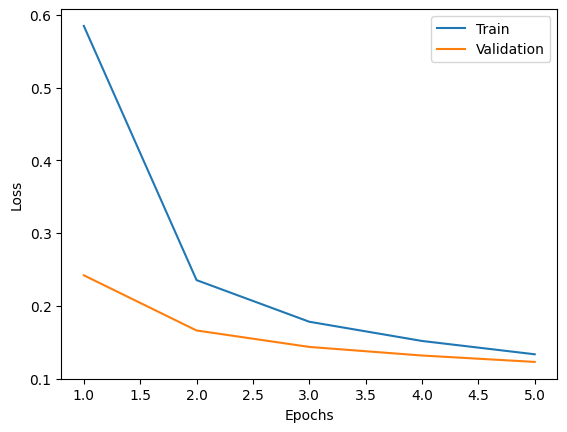

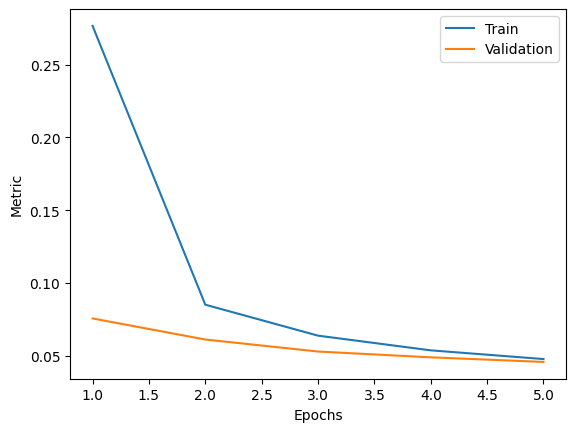

In [38]:
trainer.plot_history()

In [39]:
trainer.best_epoch

5

In [40]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/NLP/assignment6/rev2/checkpoint_2023-04-10_02-49-01_best.pt'.


In [41]:
trainer.train(num_epochs=10, multilabel=True)

Epoch 1/10 - Train Loss: 0.1195, Train Metric: 0.0426, Train Time: 0:00:03.350878
Epoch 1/10 - Val Loss: 0.1166, Val Metric: 0.0432, Val Time: 0:00:00.844351

Epoch 2/10 - Train Loss: 0.1085, Train Metric: 0.0385, Train Time: 0:00:03.406050
Epoch 2/10 - Val Loss: 0.1106, Val Metric: 0.0403, Val Time: 0:00:00.850658

Epoch 3/10 - Train Loss: 0.0992, Train Metric: 0.0356, Train Time: 0:00:03.319957
Epoch 3/10 - Val Loss: 0.1070, Val Metric: 0.0389, Val Time: 0:00:00.853254

Epoch 4/10 - Train Loss: 0.0903, Train Metric: 0.0322, Train Time: 0:00:03.373187
Epoch 4/10 - Val Loss: 0.1041, Val Metric: 0.0373, Val Time: 0:00:00.857853

Epoch 5/10 - Train Loss: 0.0822, Train Metric: 0.0295, Train Time: 0:00:03.395988
Epoch 5/10 - Val Loss: 0.1020, Val Metric: 0.0361, Val Time: 0:00:00.857387

Epoch 6/10 - Train Loss: 0.0756, Train Metric: 0.0273, Train Time: 0:00:03.397108
Epoch 6/10 - Val Loss: 0.1017, Val Metric: 0.0355, Val Time: 0:00:00.900148

Epoch 7/10 - Train Loss: 0.0705, Train Metric:

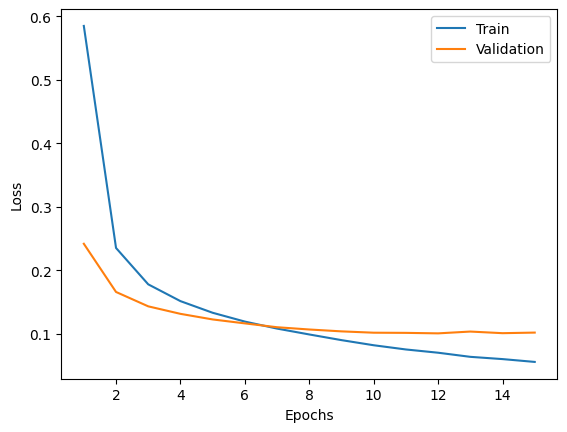

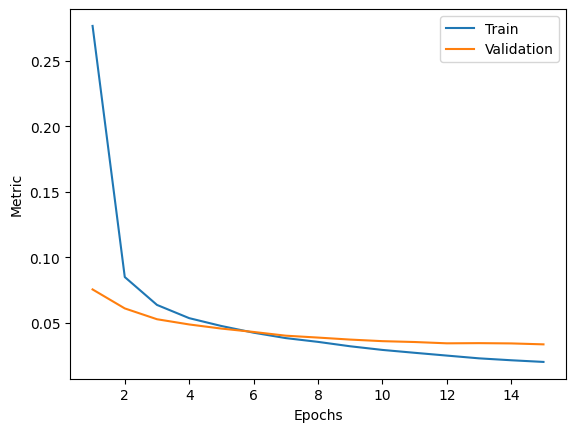

In [42]:
trainer.plot_history()

In [43]:
trainer.best_epoch

11

#Get Accuracy, Predictions

In [44]:
#testset = CustomDataset(X_test, y_test)

In [45]:
test_multilabel_vocab = get_vocab(testset, min_freq=2)

In [46]:
collate_fn = partial(collate_batch_multilabel, vocab=test_multilabel_vocab)
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [47]:
for (texts, offsets), labels in train_loader:
  print(labels, texts, offsets)
  break

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.]]) tensor([ 741,   99,   96,  ...,  428, 2280, 1584]) tensor([    0,   171,   517,   624,   719,   798,  1299,  1392,  1469,  1505,
         1525,  1611,  1667,  2002,  2092,  2156,  2320,  2355,  2416,  2466,
         2504,  2571,  2634,  2669,  2725,  2823,  2923,  2989,  3020,  3214,
         3349,  3378,  3398,  3417,  3471,  3522,  3540,  3572,  3651,  3733,
         3798,  3818,  3886,  3931,  4129,  4144,  4166,  4233,  4342,  4419,
         4621,  4660,  4719,  4753,  4767,  4801,  4862,  4917,  4962,  4980,
         5182,  5286,  5334,  5386,  5848,  5868,  5970,  6117,  6499,  6550,
         6576,  6617,  6629,  6767,  6897,  6964,  6973,  7039,  7109,  7211,
         7262,  7272,  7285,  7318,  7469,  7609,  7658,  7699,  7731, 

In [48]:
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True, multilabel=True)
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True, multilabel=True)

In [49]:
print(target_train.shape, predictions_train.shape)
print(target_valid.shape, predictions_valid.shape)
print(target_test.shape, predictions_test.shape)

torch.Size([28456, 10]) torch.Size([28456, 10])
torch.Size([9485, 10]) torch.Size([9485, 10])
torch.Size([9486, 10]) torch.Size([9486, 10])


In [50]:
import torchmetrics

In [52]:
#from sklearn.metrics import accuracy_score, f1_score
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
num_classes = target_train.shape[-1]
f1_score_train = multilabel_f1_score(target_train, predictions_train, average='micro',num_labels=num_classes)
hamming_distance_train = multilabel_hamming_distance(target_train,predictions_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)
num_classes = target_valid.shape[-1]
f1_score_valid = multilabel_f1_score(target_valid,predictions_valid, average='micro',num_labels=num_classes)
hamming_distance_valid = multilabel_hamming_distance(target_valid,predictions_valid, num_labels=num_classes)
print("Train F1 Score: ",f1_score_valid, " Train hamming distance: ", hamming_distance_valid)
num_classes = target_test.shape[-1]
f1_score_test = multilabel_f1_score(target_test, predictions_test, average='micro', num_labels=num_classes)
hamming_distance_test = multilabel_hamming_distance(target_test,predictions_test,num_labels=num_classes)
print("Test F1 Score: ",f1_score_test, " Test hamming distance: ", hamming_distance_test)

Train F1 Score:  tensor(0.9749)  Train hamming distance:  tensor(0.0104)
Train F1 Score:  tensor(0.9181)  Train hamming distance:  tensor(0.0337)
Test F1 Score:  tensor(0.3510)  Test hamming distance:  tensor(0.2582)
